# Stance Classification Visualization

Visualize stance distribution (favor, against, neutral) by party (pro ruling vs pro opposition).

**Features:**
- Grouped bar plots
- Stacked bar plots
- Per-keyword breakdown
- Automatic loading from temp files or final results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import glob
import warnings
warnings.filterwarnings('ignore')

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Colors for stances
STANCE_COLORS = {
    'favor': '#2ecc71',     # Green
    'against': '#e74c3c',   # Red
    'neutral': '#95a5a6'    # Gray
}

PARTY_COLORS = {
    'pro ruling': '#FF6B35',      # Orange
    'pro opposition': '#004E89'   # Blue
}

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# ============================================================================
# DATA LOADING - Tries temp files first, falls back to final results
# ============================================================================

# Paths
TEMP_PATTERN = "/tmp/stance_parallel_*/outputs/result_*.csv"
FINAL_CSV = "/scratch/ziv_baretto/Research_X/Partisan-Discourse-on-X-English-/codes/6_stance/stance_results.csv"

def load_stance_data():
    """Load stance results from temp files or final CSV."""
    
    # Try temp files first
    temp_files = glob.glob(TEMP_PATTERN)
    if temp_files:
        print(f"Loading from {len(temp_files)} temporary files...")
        dfs = [pd.read_csv(f) for f in sorted(temp_files)]
        df = pd.concat(dfs, axis=0, ignore_index=True)
        print(f"Loaded {len(df):,} rows from temp files")
    elif Path(FINAL_CSV).exists():
        print(f"Loading from final CSV: {FINAL_CSV}")
        df = pd.read_csv(FINAL_CSV)
        print(f"Loaded {len(df):,} rows")
    else:
        raise FileNotFoundError("No stance results found! Run inference first.")
    
    return df

df = load_stance_data()
print(f"\nColumns: {df.columns.tolist()}")

Loading from final CSV: /scratch/ziv_baretto/Research_X/Partisan-Discourse-on-X-English-/codes/6_stance/stance_results.csv
Loaded 141,311 rows

Columns: ['source_row', 'tweet', 'tweet_label', '_label_norm', 'keyword', 'subjects_scored', 'stance_gold', 'fewshot_raw', 'fewshot_label', 'fewshot_label_for_against', 'fewshot_reason', 'fewshot_shots_json']


In [3]:
# ============================================================================
# DATA PREPARATION
# ============================================================================

# Filter to only rows with valid stance labels
valid_stances = ['favor', 'against', 'neutral']
df_valid = df[df['fewshot_label'].isin(valid_stances)].copy()

print(f"Total rows: {len(df):,}")
print(f"Rows with valid stance labels: {len(df_valid):,}")
print(f"Rows pending inference: {len(df) - len(df_valid):,}\n")

# Rename for clarity
df_valid['stance'] = df_valid['fewshot_label']
df_valid['party'] = df_valid['_label_norm']

# Show distribution
print("=" * 50)
print("STANCE DISTRIBUTION")
print("=" * 50)
print(df_valid['stance'].value_counts())

print("\n" + "=" * 50)
print("PARTY DISTRIBUTION")
print("=" * 50)
print(df_valid['party'].value_counts())

Total rows: 141,311
Rows with valid stance labels: 141,311
Rows pending inference: 0

STANCE DISTRIBUTION
stance
favor      71234
against    47383
neutral    22694
Name: count, dtype: int64

PARTY DISTRIBUTION
party
pro ruling        88403
pro opposition    52908
Name: count, dtype: int64


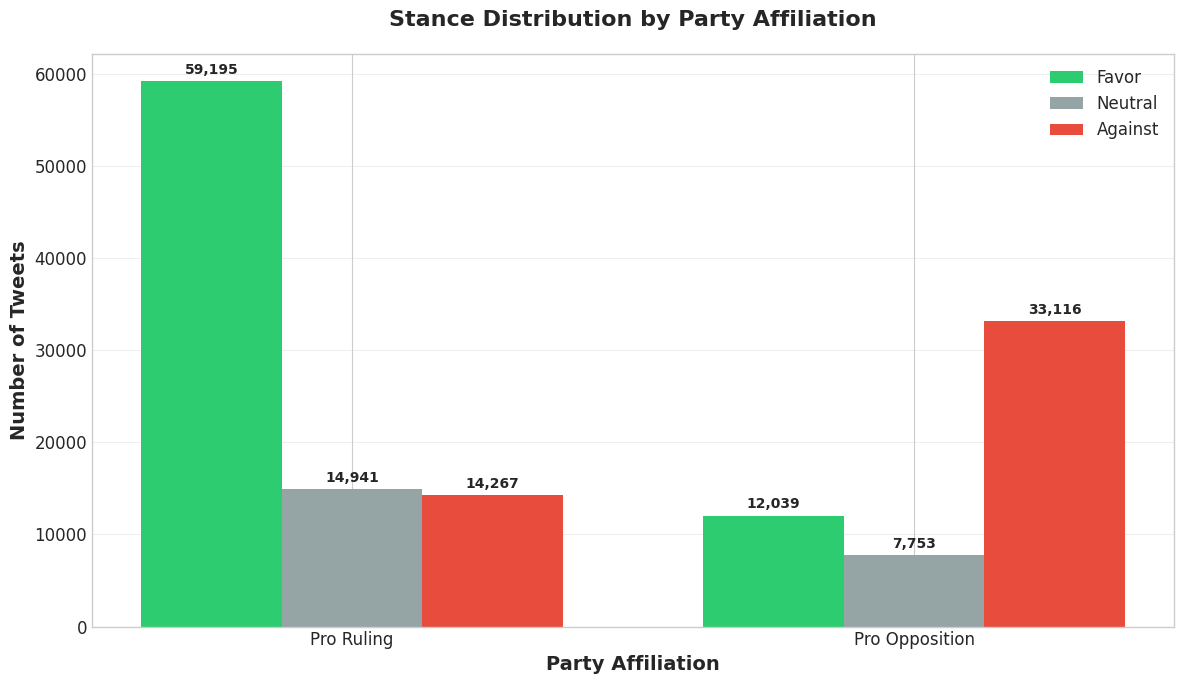

Saved: stance_by_party_grouped.png


In [4]:
# ============================================================================
# PLOT 1: Overall Stance Distribution by Party (Grouped Bar)
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 7))

# Create cross-tabulation
ct = pd.crosstab(df_valid['party'], df_valid['stance'])
ct = ct.reindex(['pro ruling', 'pro opposition'])
ct = ct[['favor', 'neutral', 'against']]  # Order columns

# Plot grouped bar
x = np.arange(len(ct.index))
width = 0.25

bars1 = ax.bar(x - width, ct['favor'], width, label='Favor', color=STANCE_COLORS['favor'])
bars2 = ax.bar(x, ct['neutral'], width, label='Neutral', color=STANCE_COLORS['neutral'])
bars3 = ax.bar(x + width, ct['against'], width, label='Against', color=STANCE_COLORS['against'])

# Add value labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height):,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

ax.set_xlabel('Party Affiliation', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Tweets', fontsize=14, fontweight='bold')
ax.set_title('Stance Distribution by Party Affiliation', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([p.title() for p in ct.index], fontsize=12)
ax.legend(loc='upper right', fontsize=12)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('stance_by_party_grouped.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: stance_by_party_grouped.png")

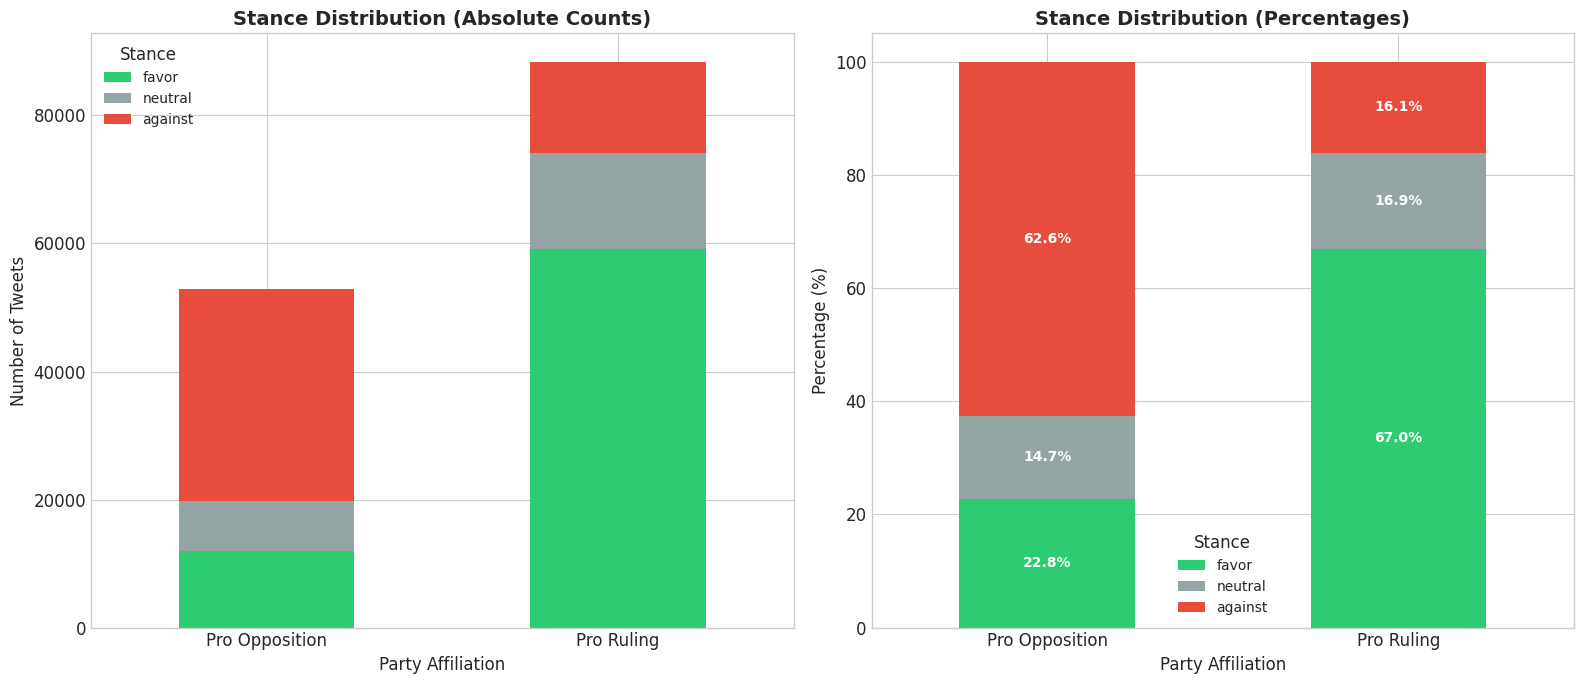

Saved: stance_by_party_stacked.png


In [5]:
# ============================================================================
# PLOT 2: Stacked Bar Chart (Proportions)
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: Absolute counts
ct = pd.crosstab(df_valid['party'], df_valid['stance'])
ct = ct[['favor', 'neutral', 'against']]
ct.plot(kind='bar', stacked=True, ax=axes[0], 
        color=[STANCE_COLORS['favor'], STANCE_COLORS['neutral'], STANCE_COLORS['against']])
axes[0].set_title('Stance Distribution (Absolute Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Party Affiliation', fontsize=12)
axes[0].set_ylabel('Number of Tweets', fontsize=12)
axes[0].set_xticklabels([p.title() for p in ct.index], rotation=0)
axes[0].legend(title='Stance', fontsize=10)

# Right: Proportions (normalized)
ct_norm = ct.div(ct.sum(axis=1), axis=0) * 100
ct_norm.plot(kind='bar', stacked=True, ax=axes[1],
             color=[STANCE_COLORS['favor'], STANCE_COLORS['neutral'], STANCE_COLORS['against']])
axes[1].set_title('Stance Distribution (Percentages)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Party Affiliation', fontsize=12)
axes[1].set_ylabel('Percentage (%)', fontsize=12)
axes[1].set_xticklabels([p.title() for p in ct_norm.index], rotation=0)
axes[1].legend(title='Stance', fontsize=10)

# Add percentage labels
for i, party in enumerate(ct_norm.index):
    cumsum = 0
    for stance in ['favor', 'neutral', 'against']:
        val = ct_norm.loc[party, stance]
        if val > 5:  # Only show if > 5%
            axes[1].text(i, cumsum + val/2, f'{val:.1f}%', 
                        ha='center', va='center', fontsize=10, fontweight='bold', color='white')
        cumsum += val

plt.tight_layout()
plt.savefig('stance_by_party_stacked.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: stance_by_party_stacked.png")

Found 15 keywords


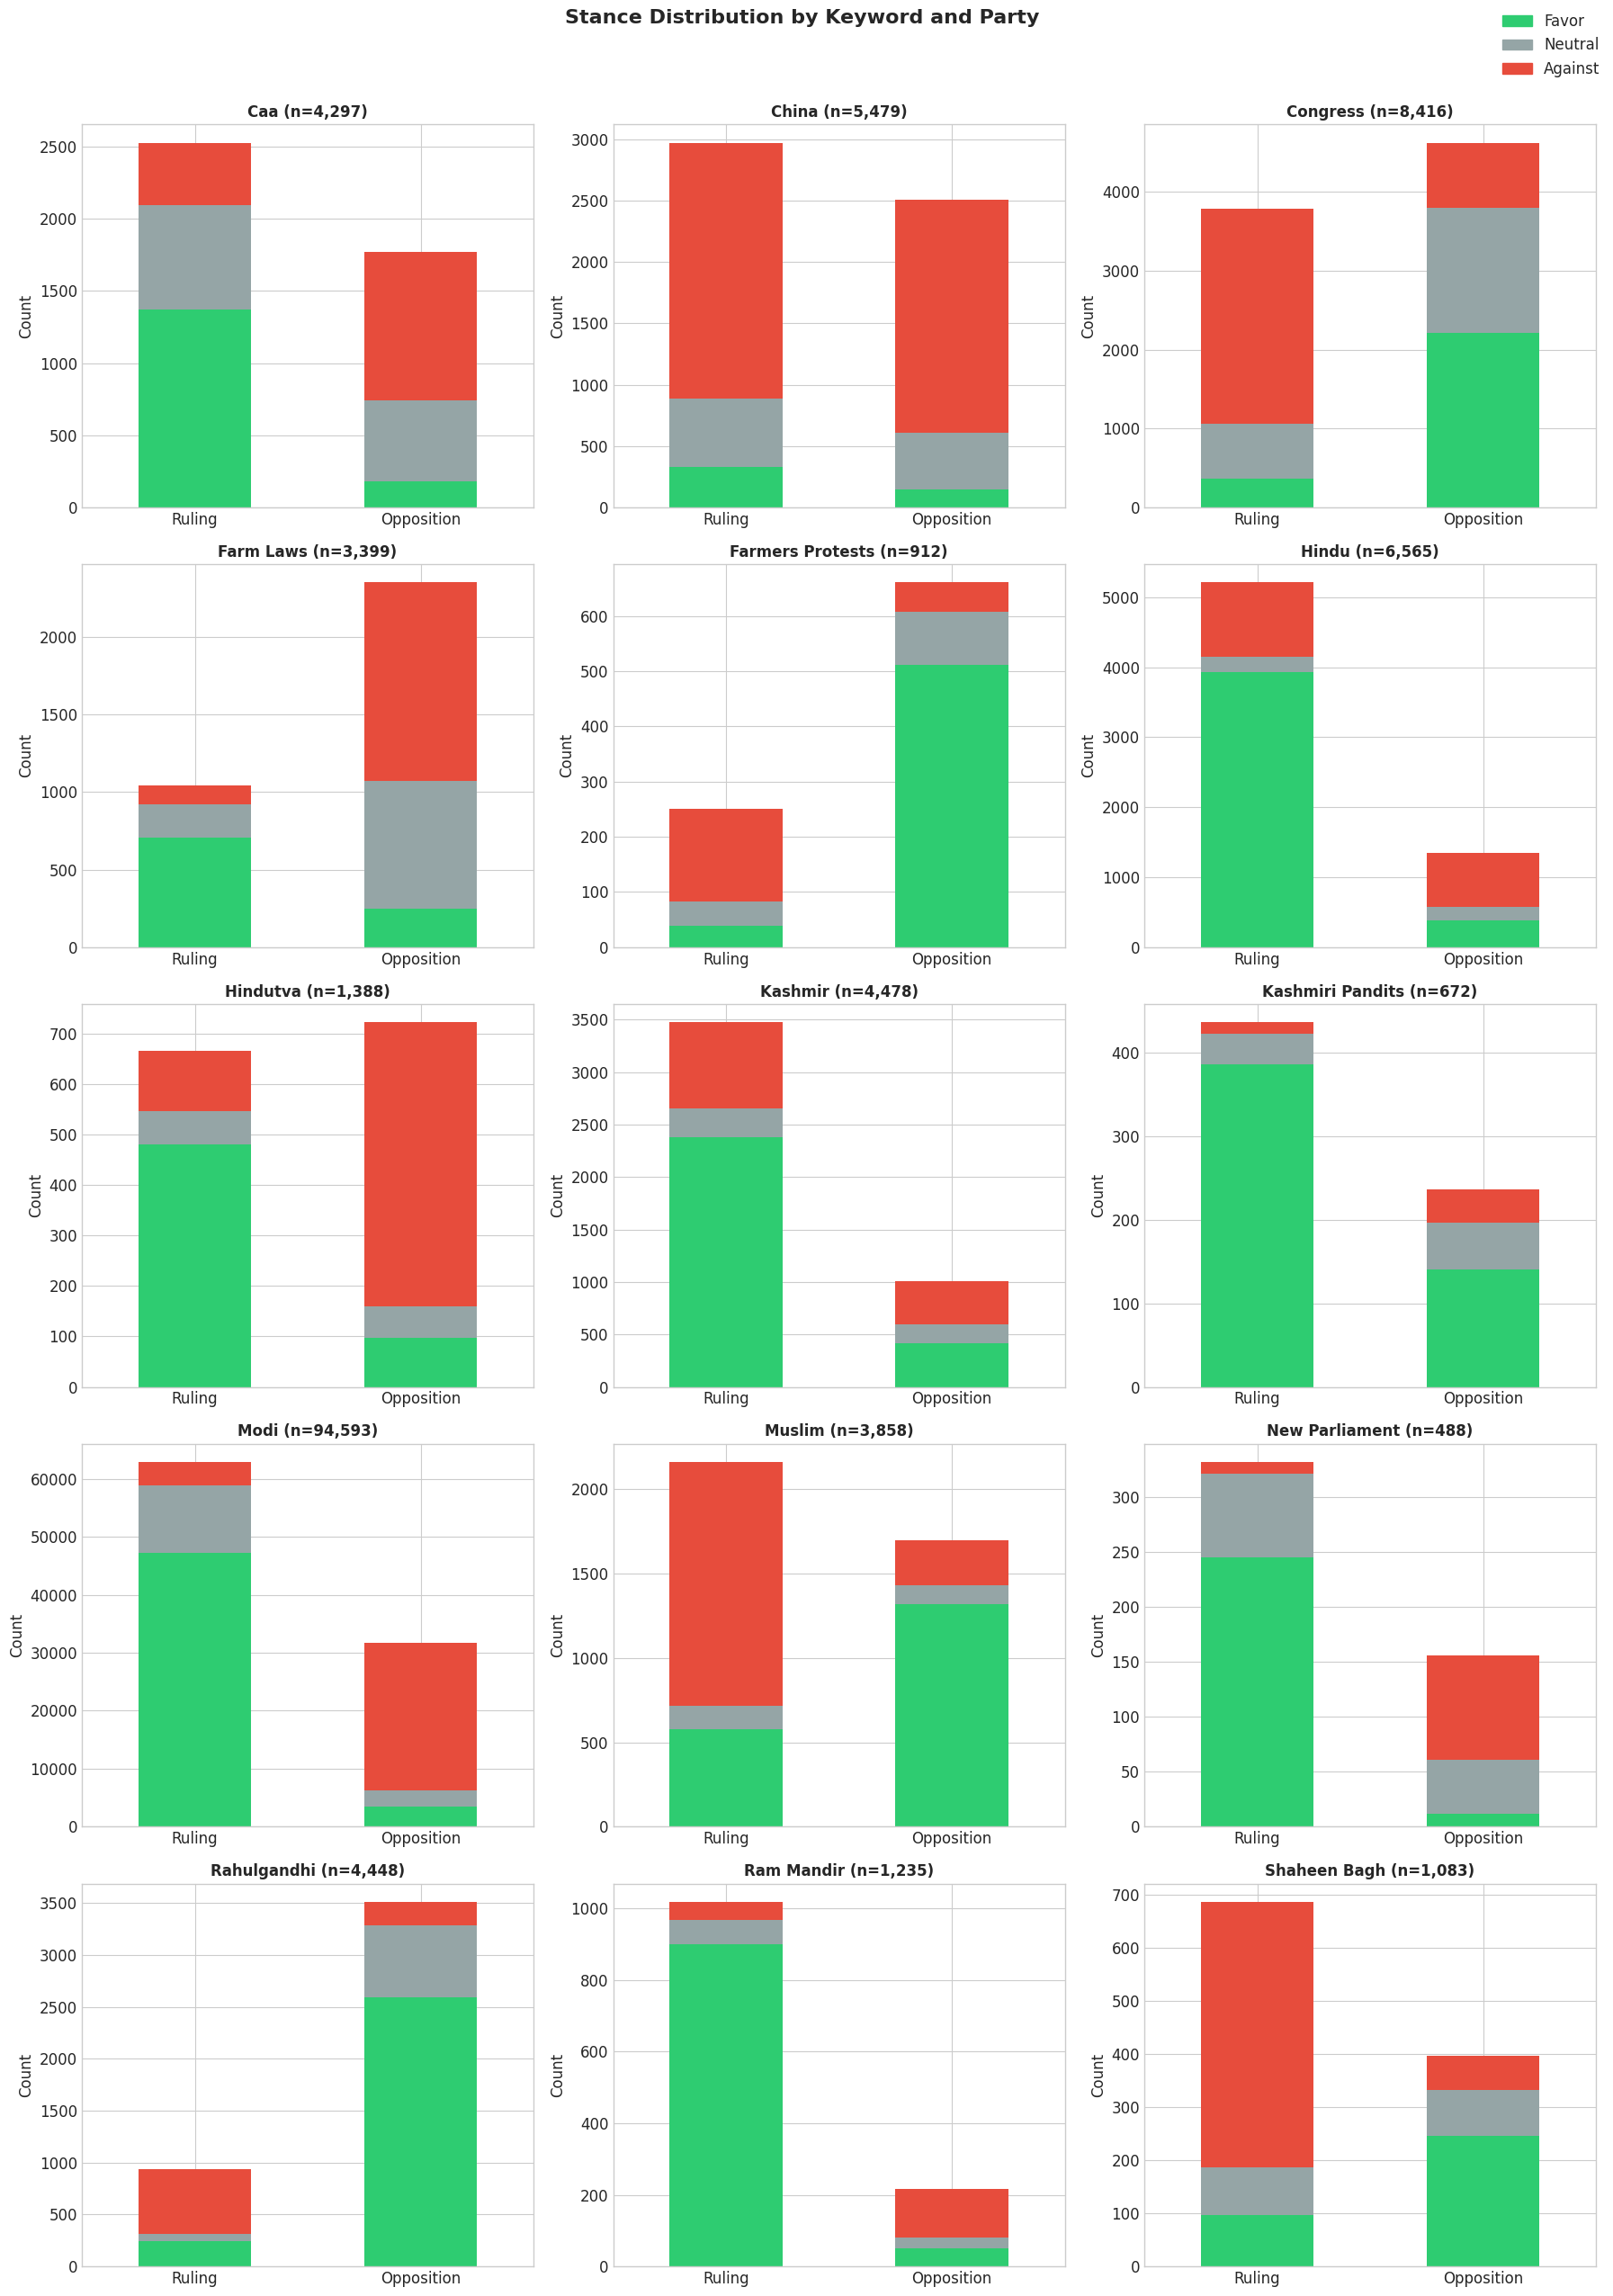

Saved: stance_by_keyword.png


In [6]:
# ============================================================================
# PLOT 3: Stance by Keyword (Faceted)
# ============================================================================

# Get unique keywords
keywords = df_valid['keyword'].unique()
n_keywords = len(keywords)
print(f"Found {n_keywords} keywords")

# Create grid
n_cols = 3
n_rows = (n_keywords + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, kw in enumerate(sorted(keywords)):
    ax = axes[i]
    kw_data = df_valid[df_valid['keyword'] == kw]
    
    # Cross-tab for this keyword
    ct = pd.crosstab(kw_data['party'], kw_data['stance'])
    ct = ct.reindex(['pro ruling', 'pro opposition'])
    for col in ['favor', 'neutral', 'against']:
        if col not in ct.columns:
            ct[col] = 0
    ct = ct[['favor', 'neutral', 'against']]
    
    # Plot
    ct.plot(kind='bar', stacked=True, ax=ax,
            color=[STANCE_COLORS['favor'], STANCE_COLORS['neutral'], STANCE_COLORS['against']],
            legend=False)
    ax.set_title(f'{kw.title()} (n={len(kw_data):,})', fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.set_xticklabels([p.replace('pro ', '').title() for p in ct.index], rotation=0)

# Hide empty subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Add shared legend
handles = [plt.Rectangle((0,0),1,1, color=STANCE_COLORS[s]) for s in ['favor', 'neutral', 'against']]
fig.legend(handles, ['Favor', 'Neutral', 'Against'], loc='upper right', fontsize=12)

plt.suptitle('Stance Distribution by Keyword and Party', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('stance_by_keyword.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: stance_by_keyword.png")

Found 15 keywords


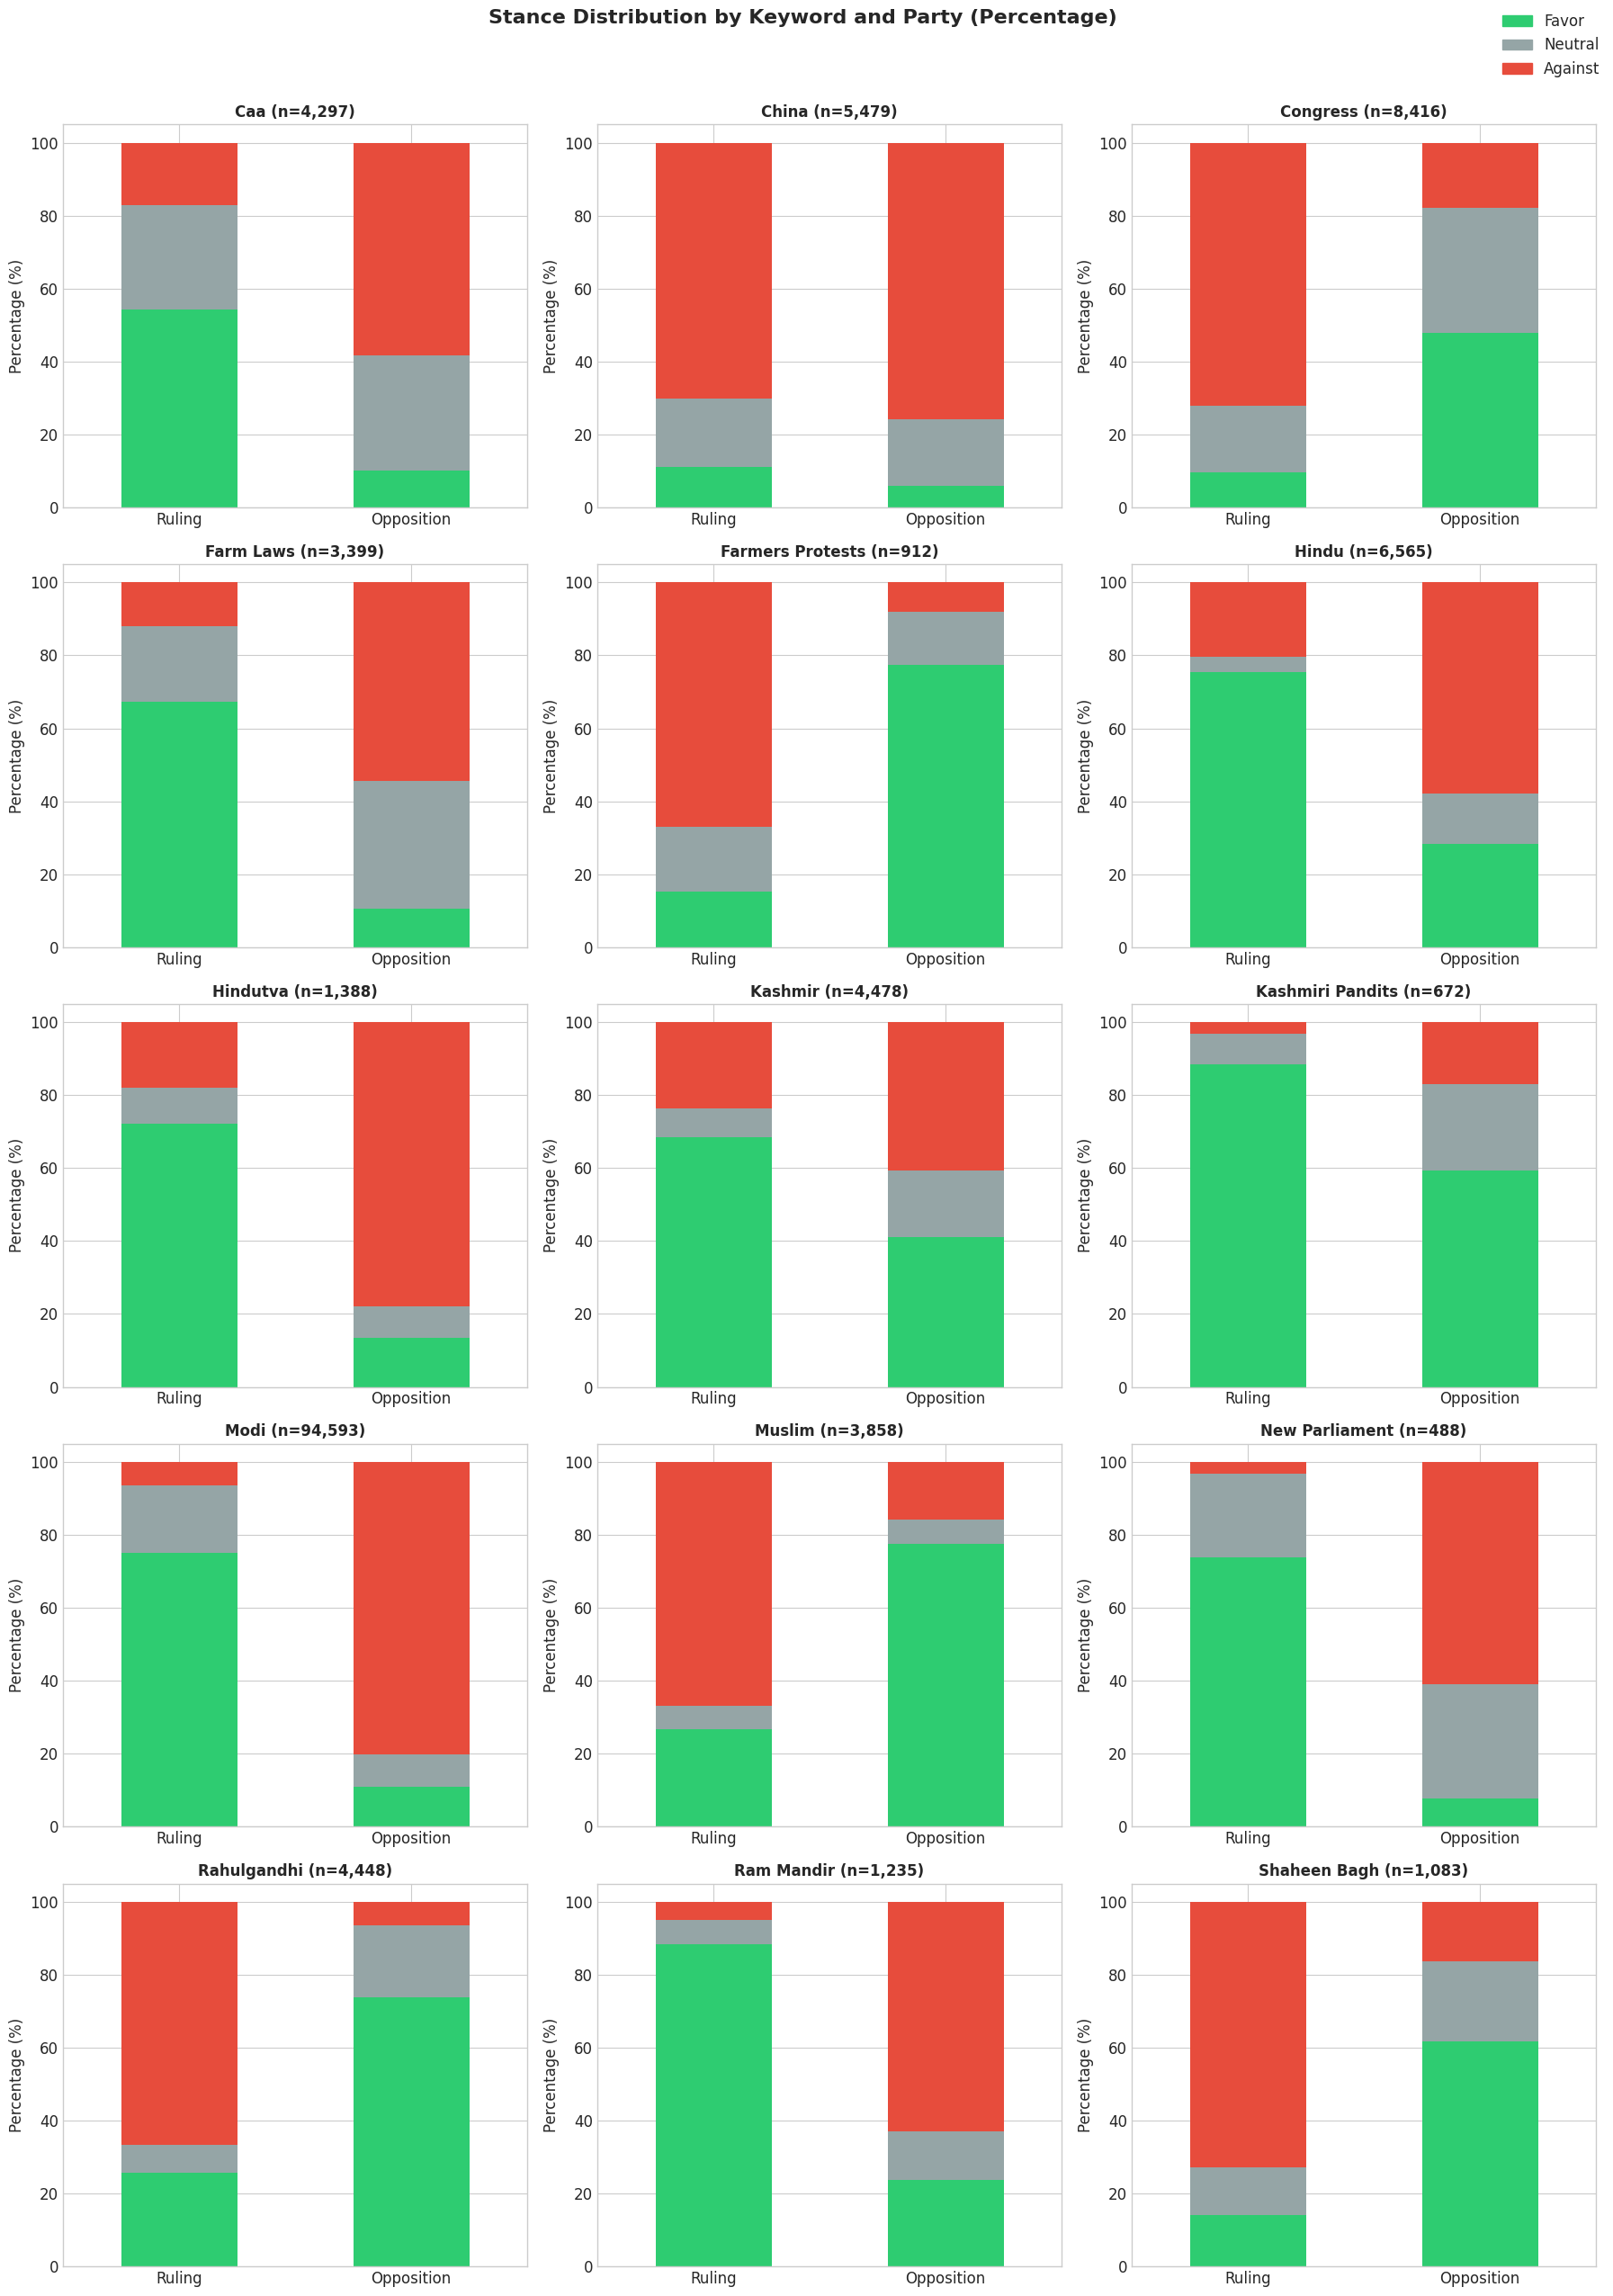

Saved: stance_by_keyword_pct.png


In [7]:
# ============================================================================
# PLOT 3b: Stance by Keyword (Faceted, Percentage)
# ============================================================================

# Get unique keywords
keywords = df_valid['keyword'].unique()
n_keywords = len(keywords)
print(f"Found {n_keywords} keywords")

# Create grid
n_cols = 3
n_rows = (n_keywords + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, kw in enumerate(sorted(keywords)):
    ax = axes[i]
    kw_data = df_valid[df_valid['keyword'] == kw]
    
    # Cross-tab for this keyword
    ct = pd.crosstab(kw_data['party'], kw_data['stance'], normalize='index') * 100
    ct = ct.reindex(['pro ruling', 'pro opposition'])
    for col in ['favor', 'neutral', 'against']:
        if col not in ct.columns:
            ct[col] = 0
    ct = ct[['favor', 'neutral', 'against']]
    
    # Plot
    ct.plot(kind='bar', stacked=True, ax=ax,
            color=[STANCE_COLORS['favor'], STANCE_COLORS['neutral'], STANCE_COLORS['against']],
            legend=False)
    ax.set_title(f'{kw.title()} (n={len(kw_data):,})', fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Percentage (%)')
    ax.set_xticklabels([p.replace('pro ', '').title() for p in ct.index], rotation=0)

# Hide empty subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Add shared legend
handles = [plt.Rectangle((0,0),1,1, color=STANCE_COLORS[s]) for s in ['favor', 'neutral', 'against']]
fig.legend(handles, ['Favor', 'Neutral', 'Against'], loc='upper right', fontsize=12)

plt.suptitle('Stance Distribution by Keyword and Party (Percentage)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('stance_by_keyword_pct.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: stance_by_keyword_pct.png")

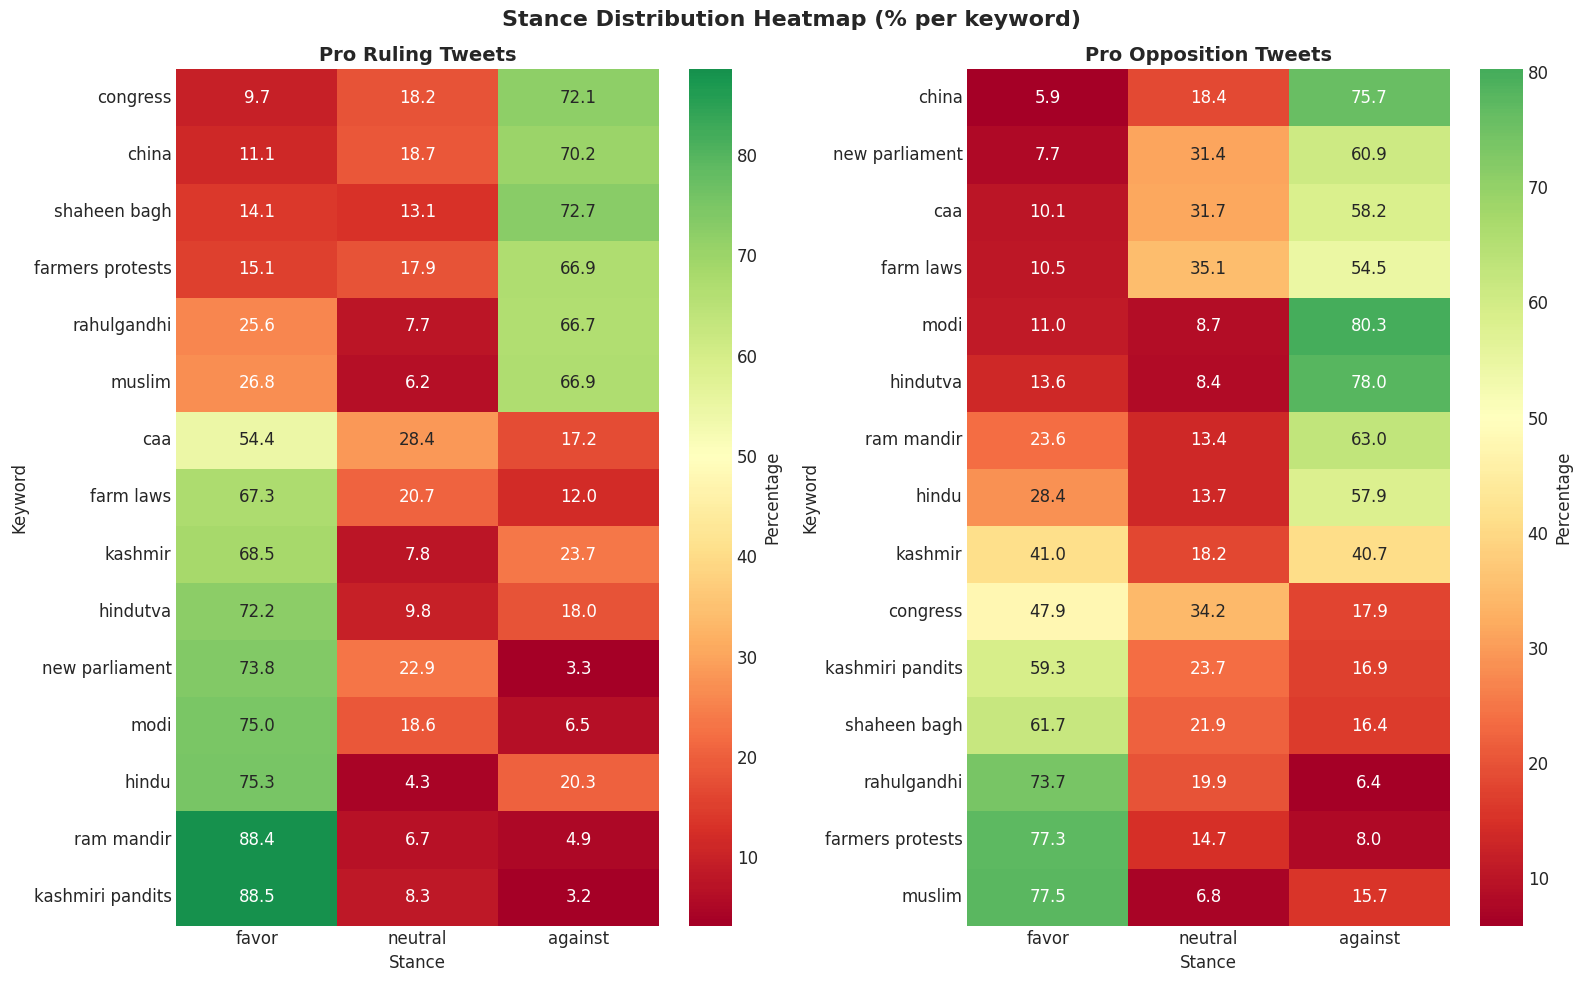

Saved: stance_heatmap.png


In [8]:
# ============================================================================
# PLOT 4: Heatmap of Stance Proportions by Keyword
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

for idx, party in enumerate(['pro ruling', 'pro opposition']):
    ax = axes[idx]
    party_data = df_valid[df_valid['party'] == party]
    
    # Create pivot table
    pivot = pd.crosstab(party_data['keyword'], party_data['stance'], normalize='index') * 100
    for col in ['favor', 'neutral', 'against']:
        if col not in pivot.columns:
            pivot[col] = 0
    pivot = pivot[['favor', 'neutral', 'against']]
    pivot = pivot.sort_values('favor', ascending=True)
    
    # Heatmap
    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn', center=50,
                ax=ax, cbar_kws={'label': 'Percentage'})
    ax.set_title(f'{party.title()} Tweets', fontsize=14, fontweight='bold')
    ax.set_xlabel('Stance', fontsize=12)
    ax.set_ylabel('Keyword', fontsize=12)

plt.suptitle('Stance Distribution Heatmap (% per keyword)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('stance_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: stance_heatmap.png")

In [9]:
# ============================================================================
# SUMMARY TABLE
# ============================================================================

print("=" * 80)
print("SUMMARY TABLE: Stance by Party and Keyword")
print("=" * 80)

summary = df_valid.groupby(['keyword', 'party', 'stance']).size().unstack(fill_value=0)
summary['total'] = summary.sum(axis=1)

# Calculate percentages
for stance in ['favor', 'against', 'neutral']:
    if stance in summary.columns:
        summary[f'{stance}_%'] = (summary[stance] / summary['total'] * 100).round(1)

print(summary.to_string())

# Save to CSV
summary.to_csv('stance_summary.csv')
print("\nSaved: stance_summary.csv")

SUMMARY TABLE: Stance by Party and Keyword
stance                           against  favor  neutral  total  favor_%  against_%  neutral_%
keyword          party                                                                        
caa              pro opposition     1030    179      560   1769     10.1       58.2       31.7
                 pro ruling          435   1374      719   2528     54.4       17.2       28.4
china            pro opposition     1899    147      461   2507      5.9       75.7       18.4
                 pro ruling         2085    331      556   2972     11.1       70.2       18.7
congress         pro opposition      828   2216     1582   4626     47.9       17.9       34.2
                 pro ruling         2734    366      690   3790      9.7       72.1       18.2
farm laws        pro opposition     1282    246      825   2353     10.5       54.5       35.1
                 pro ruling          125    704      217   1046     67.3       12.0       20.7
farmers

In [10]:
# ============================================================================
# INFERENCE PROGRESS CHECK
# ============================================================================

total_rows = len(df)
completed_rows = len(df_valid)
pending_rows = total_rows - completed_rows
progress_pct = completed_rows / total_rows * 100

print("=" * 50)
print("INFERENCE PROGRESS")
print("=" * 50)
print(f"Total rows:     {total_rows:,}")
print(f"Completed:      {completed_rows:,} ({progress_pct:.1f}%)")
print(f"Pending:        {pending_rows:,}")
print("=" * 50)

# Progress bar visualization
bar_length = 40
filled = int(bar_length * progress_pct / 100)
bar = '█' * filled + '░' * (bar_length - filled)
print(f"\n[{bar}] {progress_pct:.1f}%")

INFERENCE PROGRESS
Total rows:     141,311
Completed:      141,311 (100.0%)
Pending:        0

[████████████████████████████████████████] 100.0%
